# 3W - Strategy Thinking project

In [24]:
# IMPORTS AND CONFIGURATIONS

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import glob
import os
import time

from sklearn.dummy import DummyClassifier
import sklearn.metrics as metrics

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay

import pickle
from sklearn.pipeline import make_pipeline

## Data Preparation

Preprocessing a dataset through data characterisation involves summarising the features and characteristics present in the data using statistical measures and visualisations techniques such as bar charts and scatter plots. After this stage, it should be possible to identify biases, patterns, trends, and any missing or irrelevant data in the data set that may need to be addressed.

This dataset is composed by instances of eight types of undesirable events characterized by eight process variables from three different sources: real instances, simulated instances and hand-drawn instances. All real instances were taken from the plant information system that is used to monitor the industrial processes at an operational unit in Brazilian state of Espírito Santo. The simulated instances were all generated using OLGA ([Schlumberger](https://www.software.slb.com/products/olga)), a dynamic multiphase flow simulator that is widely used by oil companies worldwide (Andreolli, 2016). Finally, the hand-drawn instances were generated by a specific tool developed by Petrobras researchers for this dataset to incorporate undesirable events classfied as rare. 
 
### Data Characterisation
The data consists of over 50 million observations, with 13 columns of data for each observation. The first column, `label`, indicates the event type for each observation. The second column, `well`, contains the name of the well the observation was taken from. Hand-drawn and simulated instances have fixed names for in this column, while real instances have names masked with incremental id. The third column, `id`, is an identifier for the observation and it is incremental for hand-drawn and simulated instances, while each real instance has an id generated from its first timestamp. The columns representing the process variables are:

* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG) - installed on Christmas Tree;
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT) - installed on Christmas Tree;
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP) - located on platform;
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;

The pressure features are measured in Pascal (Pa), the volumetric flow rate features are measured in standard cubic meters per second (SCM/s), and the temperature features are measured in degrees Celsius (°C).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type) - target variable;
* **well**: well name. Hand-drawn and simulated instances have fixed names (respectively, `drawn` and `simulated`. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp;
* **class**: Although it can be used to identify periods of normal operation, fault transients, and faulty steady states, which can help with diagnosis and maintenance, it is a category which results from label, which is our target here

The labels are:
* 0 - Normal Operation = `Normal`
* 1 - Abrupt Increase of BSW = `AbrIncrBSW`
* 2 - Spurious Closure of DHSV = `SpurClosDHSW`
* 3 - Severe Slugging = `SevSlug`
* 4 - Flow Instability = `FlowInst`
* 5 - Rapid Productivity Loss = `RProdLoss`
* 6 - Quick Restriction in PCK	= `QuiRestrPCK`
* 7 - Scaling in PCK = `ScalingPCK`
* 8 - Hydrate in Production Line = `HydrProdLine`

More information about these variables can be obtained from the following publicly available documents:

* ***Option in Portuguese***: R.E.V. Vargas. Base de dados e benchmarks para prognóstico de anomalias em sistemas de elevação de petróleo. Universidade Federal do Espírito Santo. Doctoral thesis. 2019. https://github.com/petrobras/3W/raw/master/docs/doctoral_thesis_ricardo_vargas.pdf.
* ***Option in English***: B.G. Carvalho. Evaluating machine learning techniques for detection of flow instability events in offshore oil wells. Universidade Federal do Espírito Santo. Master's degree dissertation. 2021. https://github.com/petrobras/3W/raw/master/docs/master_degree_dissertation_bruno_carvalho.pdf.

In order to maintain the realistic aspects of the data, the dataset was extracted without preprocessing, including the presence of `NaN` values, frozen variables due to sensor or communication issues, instances with varying sizes, and outliers (R.E.V. Vargas, et al. 2019). 

From all 50,822,124 entries, 3,086,851 are duplicated, that is, approximately 6.07% of total. These duplicated rows may be related to frozen variables from real instances, as simulated and hand-drawn instances are naturally free of such problems. Although no missing values were found for columns `label`, `well`, and `id`, other features presented null or absent values. Notably, the column `T-JUS-CKGL` turned out to be completely empty.

In [2]:
%%time
df = pd.read_csv('3Wdataset_real.csv', index_col=None, parse_dates=['timestamp'])

# only using real, since simulated and drawn doesnt have records for QGL and P-JUS-CKGL
# df_real.info()

# df_drawn = pd.read_csv('3Wdataset_drawn.csv', index_col=None)
# # df_drawn.info()

# df_sim1 = pd.read_csv('3Wdataset_simulated_1of2.csv', index_col=None)
# # df_sim1.info()

# df_sim2 = pd.read_csv('3Wdataset_simulated_2of2.csv', index_col=None)
# # df_sim2.info()

# df = pd.concat([
#     df_real,
#     df_sim1,
#     df_sim2,
#     df_drawn
# ])

# df = df.drop('source', axis=1)

# dismissing temporary DFs to release memory
# del df_sim1
# del df_sim2
# del df_real
# del df_drawn

df.shape

CPU times: user 19.2 s, sys: 4.82 s, total: 24 s
Wall time: 24.9 s


(13952911, 14)

### Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13952911 entries, 0 to 13952910
Data columns (total 14 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   label       int64         
 2   well        object        
 3   id          int64         
 4   P-PDG       float64       
 5   P-TPT       float64       
 6   T-TPT       float64       
 7   P-MON-CKP   float64       
 8   T-JUS-CKP   float64       
 9   P-JUS-CKGL  float64       
 10  T-JUS-CKGL  float64       
 11  QGL         float64       
 12  class       float64       
 13  source      object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 1.5+ GB


In [4]:
df.head()

,timestamp,label,well,id,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class,source
0,2017-06-25 22:01:27,0,WELL-00002,20170625220127,0.0,8698015.0,117.6015,2142158.0,75.63453,2310426.0,NaN,0.0,0.0,real
1,2017-06-25 22:01:28,0,WELL-00002,20170625220127,0.0,8698015.0,117.6014,2172395.0,75.65491,2310427.0,NaN,0.0,0.0,real
2,2017-06-25 22:01:29,0,WELL-00002,20170625220127,0.0,8698015.0,117.6013,2202631.0,75.67529,2310427.0,NaN,0.0,0.0,real
3,2017-06-25 22:01:30,0,WELL-00002,20170625220127,0.0,8698015.0,117.6012,2180472.0,75.69567,2310427.0,NaN,0.0,0.0,real
4,2017-06-25 22:01:31,0,WELL-00002,20170625220127,0.0,8698015.0,117.6011,2158313.0,75.71606,2310428.0,NaN,0.0,0.0,real


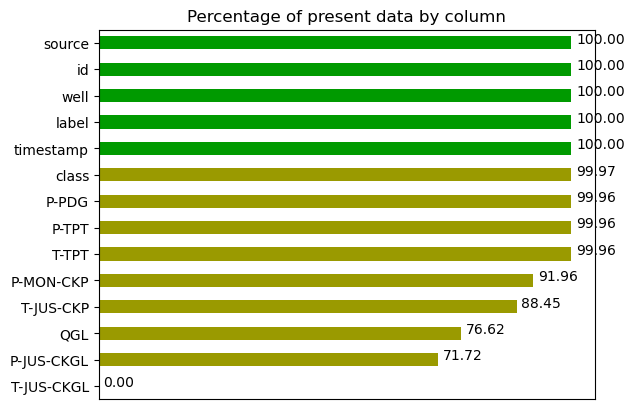

In [6]:
present_pct = df.count().sort_values() / df.shape[0] * 100

all_present = present_pct == 100
colors = all_present.map({True: '#009a00', False: '#9a9a00'})

fig, ax = plt.subplots()

ax = present_pct.plot.barh(color=colors)
ax.set_title('Percentage of present data by column')
ax.grid(False)
ax.set_facecolor('white')
ax.set_xticks([])

for i, v in enumerate(present_pct):
    ax.text(v + 1, i, f'{v:.2f}', color='black')

plt.show()

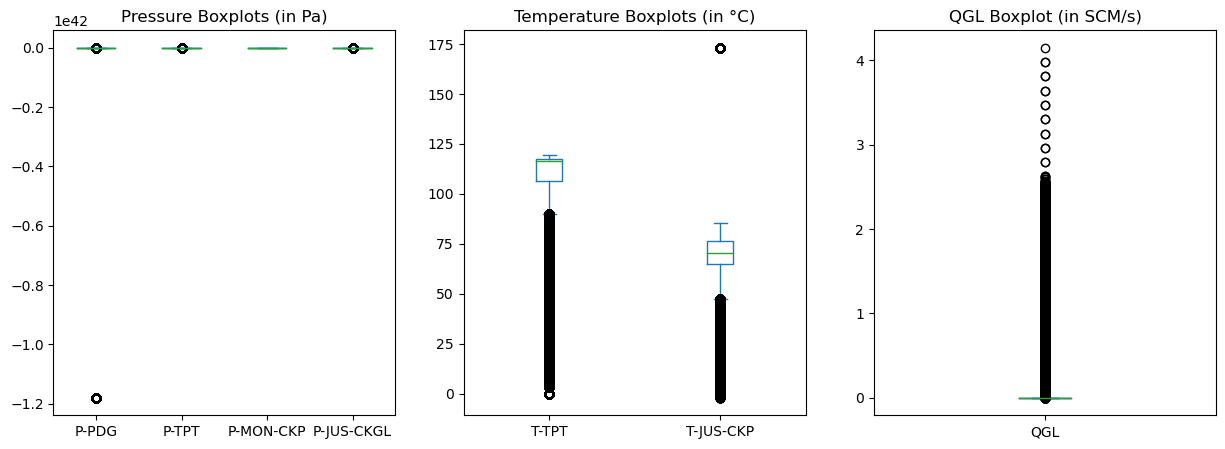

In [7]:
pressure_cols = ['P-PDG', 'P-TPT', 'P-MON-CKP', 'P-JUS-CKGL']
temp_cols = ['T-TPT', 'T-JUS-CKP']

# create a figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

df[pressure_cols].plot(kind='box', ax=axs[0])
axs[0].set_title('Pressure Boxplots (in Pa)')

df[temp_cols].plot(kind='box', ax=axs[1])
axs[1].set_title('Temperature Boxplots (in °C)')

# create boxplots for QGL
df[['QGL']].plot(kind='box', ax=axs[2])
axs[2].set_title('QGL Boxplot (in SCM/s)')

plt.show()


### Data Cleaning

In [8]:
# drop rows with missing or null class column
df_clean = df.dropna(subset=[
    'class','P-PDG','P-TPT','T-JUS-CKP','P-MON-CKP','T-TPT','P-MON-CKP','QGL','P-JUS-CKGL'
])

# first interaction will dismiss timestamp in order to remove duplicates, even if it overlooks frozen
# variables due to sensor or communication issues

# removing class, since it results from label
# removing ID from df

df_clean = df_clean.drop([
#     'timestamp', 
    'class',
    'T-JUS-CKGL', # T-JUS-CKGL is empty
    'id', 
    'source'
], axis=1)

# checking duplicated rows after removing ids
df_clean = df_clean.drop_duplicates()

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10003580 entries, 0 to 13952910
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   label       int64         
 2   well        object        
 3   P-PDG       float64       
 4   P-TPT       float64       
 5   T-TPT       float64       
 6   P-MON-CKP   float64       
 7   T-JUS-CKP   float64       
 8   P-JUS-CKGL  float64       
 9   QGL         float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 839.5+ MB


In [9]:
# Finding missing values
missing = df_clean.isnull()
missing.sum()

total_missing = df_clean.isnull().sum()
percent_missing = total_missing * 100 / len(df_clean)
missing_value_df = pd.DataFrame({'percent': percent_missing, 'total':total_missing})

# Total of Missing Values
missing_value_df.sum()

percent    0.0
total      0.0
dtype: float64

In [10]:
# removing extreme outliers from P-PDG 
Q1 = df_clean['P-PDG'].quantile(0.25)
Q3 = df_clean['P-PDG'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - (3 * IQR)
# upper_bound = Q3 + (3 * IQR)

# df_no_outliers = df_clean[(df_clean['P-PDG'] >= lower_bound) & (df_clean['P-PDG'] <= upper_bound)]
df_no_outliers = df_clean[(df_clean['P-PDG'] >= lower_bound)]


# removing extreme outliers from P-TPT
Q1 = df_no_outliers['P-TPT'].quantile(0.25)
Q3 = df_no_outliers['P-TPT'].quantile(0.75)
IQR = Q3 - Q1

# lower_bound = Q1 - (3 * IQR)
upper_bound = Q3 + (3 * IQR)

df_no_outliers = df_no_outliers[(df_no_outliers['P-TPT'] <= upper_bound)]


df_no_outliers.shape

(9780901, 10)

In [12]:
pct_removed = (df_clean.shape[0] - df_no_outliers.shape[0]) / df_clean.shape[0]
print(pct_removed)

0.02225993094472179


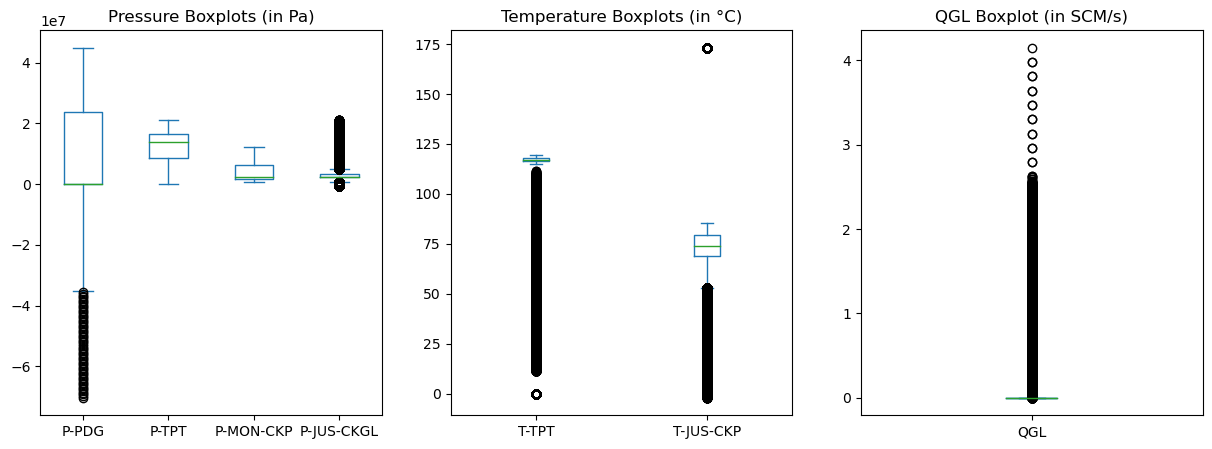

In [13]:
# figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# boxplots for pressure columns
df_no_outliers[pressure_cols].plot(kind='box', ax=axs[0])
axs[0].set_title('Pressure Boxplots (in Pa)')

# boxplots for temperature columns (but T-JUS-CKGL)
df_no_outliers[temp_cols].plot(kind='box', ax=axs[1])
axs[1].set_title('Temperature Boxplots (in °C)')

# create boxplots for QGL
df_no_outliers[['QGL']].plot(kind='box', ax=axs[2])
axs[2].set_title('QGL Boxplot (in SCM/s)')

plt.show()


### Feature Engineering

In [14]:
dt_feat = df_no_outliers

# Change 'label' column to object dtype
dt_feat['label'] = dt_feat['label'].astype('object') 

# Create boolean columns for each label
label_dummies = pd.get_dummies(dt_feat['label'], prefix='label')
dt_feat = pd.concat([dt_feat, label_dummies], axis=1)

# Rename boolean columns
column_names = {
    'label_0': 'Normal',
    'label_1': 'AbrIncrBSW',
    'label_2': 'SpurClosDHSW',
    'label_3': 'SevSlug',
    'label_4': 'FlowInst',
    'label_5': 'RProdLoss',
    'label_6': 'QuiRestrPCK',
    'label_7': 'ScalingPCK',
    'label_8': 'HydrProdLine'
}
dt_feat = dt_feat.rename(columns=column_names)

# Drop the original 'label' column and Normal column, since all other events must be 0
dt_feat = dt_feat.drop(['label','Normal'], axis=1)

dt_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9780901 entries, 0 to 13952910
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   timestamp     datetime64[ns]
 1   well          object        
 2   P-PDG         float64       
 3   P-TPT         float64       
 4   T-TPT         float64       
 5   P-MON-CKP     float64       
 6   T-JUS-CKP     float64       
 7   P-JUS-CKGL    float64       
 8   QGL           float64       
 9   AbrIncrBSW    uint8         
 10  SpurClosDHSW  uint8         
 11  SevSlug       uint8         
 12  FlowInst      uint8         
 13  RProdLoss     uint8         
 14  QuiRestrPCK   uint8         
 15  ScalingPCK    uint8         
dtypes: datetime64[ns](1), float64(7), object(1), uint8(7)
memory usage: 811.5+ MB


In [15]:
dt_feat_target = dt_feat.drop([
    'AbrIncrBSW',
    'SpurClosDHSW',
#     'SevSlug',
    'FlowInst',
    'RProdLoss',
    'QuiRestrPCK',
    'ScalingPCK'
#     ,'HydrProdLine'
], axis=1)

dt_feat_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9780901 entries, 0 to 13952910
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   timestamp   datetime64[ns]
 1   well        object        
 2   P-PDG       float64       
 3   P-TPT       float64       
 4   T-TPT       float64       
 5   P-MON-CKP   float64       
 6   T-JUS-CKP   float64       
 7   P-JUS-CKGL  float64       
 8   QGL         float64       
 9   SevSlug     uint8         
dtypes: datetime64[ns](1), float64(7), object(1), uint8(1)
memory usage: 755.6+ MB


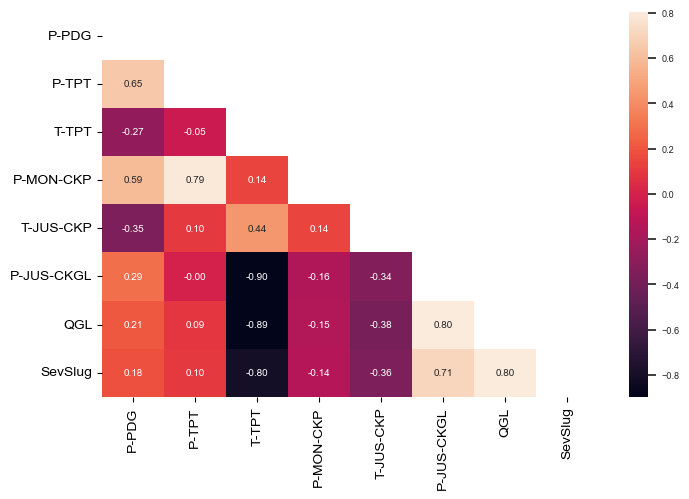

In [16]:
# Computing the correlations
corr = dt_feat_target.corr()

# Creating a boolean mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plotting the heatmap with the mask
fig, ax = plt.subplots(figsize=(8, 5))
sns.set(font_scale=0.6)
sns.heatmap(corr, annot=True, mask=mask, ax=ax, fmt='.2f')
plt.show()

### Handling Imbalanced Data

In [17]:
# defining features (X) and label (y)
target = 'SevSlug'

X = dt_feat_target.drop([target,'timestamp','well'], axis=1)
y = dt_feat_target[target]

# splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# calculating the percentage of each label in the dataset
y_train.value_counts(normalize=True)

0    0.94194
1    0.05806
Name: SevSlug, dtype: float64

In [18]:
# establishing a baseline with a DummyClassifier
dummyc = DummyClassifier()
dummyc.fit(X_train, y_train)

# retrieving score for DummyClassifier
baseline_score = dummyc.score(X_train, y_train)
y_predicted = dummyc.predict(X_test)

print("Score: ", baseline_score)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted))

Score:  0.9419403414526563
Accuracy:  0.9417780429960286


In [19]:
# balancing data 
balancing = RandomUnderSampler(random_state=42)
# balancing = SMOTE(random_state=42)
# balancing = SMOTETomek(random_state=42)

X_resampled, y_resampled = balancing.fit_resample(X, y)

In [20]:
# splitting the balanced datasets for training and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# calculating the percentage of each label in the dataset after undersampling
y_train.value_counts(normalize=True)

0    0.50003
1    0.49997
Name: SevSlug, dtype: float64

### Data Scaling

In [21]:
def plot_data_scaling(X_train_transformed, scaler_name):
    df_scaled = pd.DataFrame(X_train_transformed, columns=X_train.columns)
    df_scaled.plot(kind='box', figsize=(8, 5))

    plt.title(f'Boxplot of Features After Scaling ({scaler_name})')
    plt.xlabel('Features')
    plt.ylabel('Value')
    
    ax = plt.gca()
    ax.ticklabel_format(style='plain', axis='y', useOffset=False)
    plt.show()

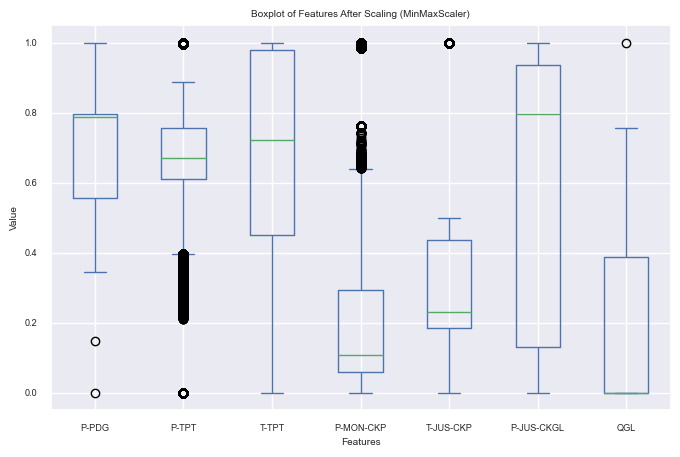

In [22]:
minmax_scaler_pipeline = make_pipeline(MinMaxScaler())
minmax_scaler_pipeline.fit(X_train)

X_train_transformed = minmax_scaler_pipeline.transform(X_train)

plot_data_scaling(X_train_transformed, 'MinMaxScaler')

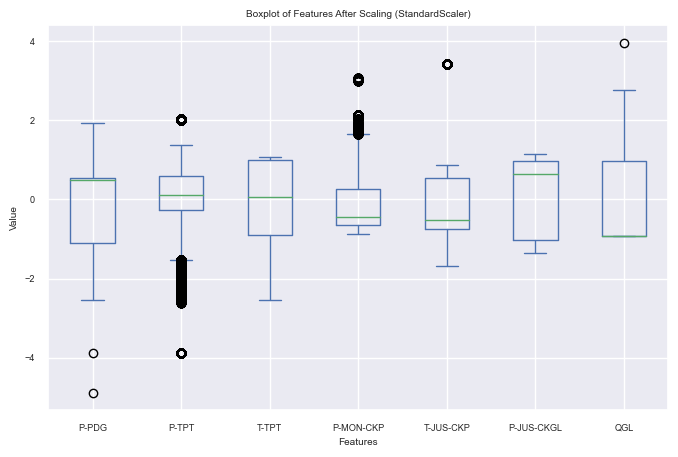

In [25]:
std_scaler_pipeline = make_pipeline(StandardScaler())
std_scaler_pipeline.fit(X_train)

X_train_transformed = std_scaler_pipeline.transform(X_train)

plot_data_scaling(X_train_transformed, 'StandardScaler')

## Dimensionality Reduction

In [26]:
from mpl_toolkits.mplot3d import Axes3D

def plot_cumul_sum(variance_captured, title):
    cum_sum_eigenvalues = np.cumsum(variance_captured)

    plt.bar(
        range(0,len(variance_captured)), 
        variance_captured, alpha=0.5, align='center', 
        label='Individual explained variance'
    )

    plt.step(
        range(0,len(cum_sum_eigenvalues)), 
        cum_sum_eigenvalues, where='mid',
        label='Cumulative explained variance'
    )

    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    sum_vc = sum(variance_captured)
    plt.title(f'Variance Captured ({title}) = {sum_vc}')
    plt.show()
    

def plot_3d_chart(X_train_reduced, y_train):
    Xax, Yax, Zax = X_train_reduced[:,0], X_train_reduced[:,1], X_train_reduced[:,2]

    cdict = {0:'green',1:'red'}
    labl = {0:'Non SevSlug',1:'SevSlug'}
    marker = {0:'*',1:'o'}
    alpha = {0:.3, 1:.5}

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection='3d')

    fig.patch.set_facecolor('white')

    for l in np.unique(y_train):
        ix=np.where(y_train==l)
        ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
               label=labl[l], marker=marker[l], alpha=alpha[l])

    # for loop ends
    ax.set_xlabel("1st Prin. Component", fontsize=14)
    ax.set_ylabel("2nd Prin. Component", fontsize=14)
    ax.set_zlabel("3rd Prin. Component", fontsize=14)

    ax.legend()
    plt.show()

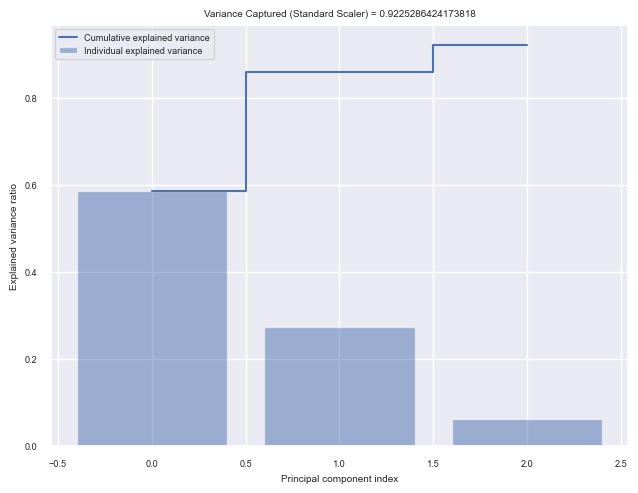

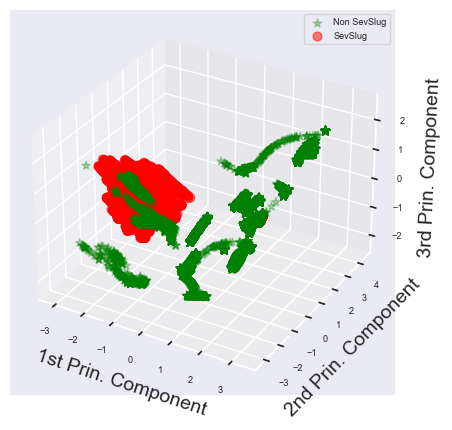

In [27]:
preproc_pipeline = make_pipeline(std_scaler_pipeline, PCA(n_components=3))
preproc_pipeline.fit(X_train)
X_train_reduced = preproc_pipeline.transform(X_train)
plot_cumul_sum(preproc_pipeline.named_steps['pca'].explained_variance_ratio_, 'Standard Scaler')
plot_3d_chart(X_train_reduced, y_train)

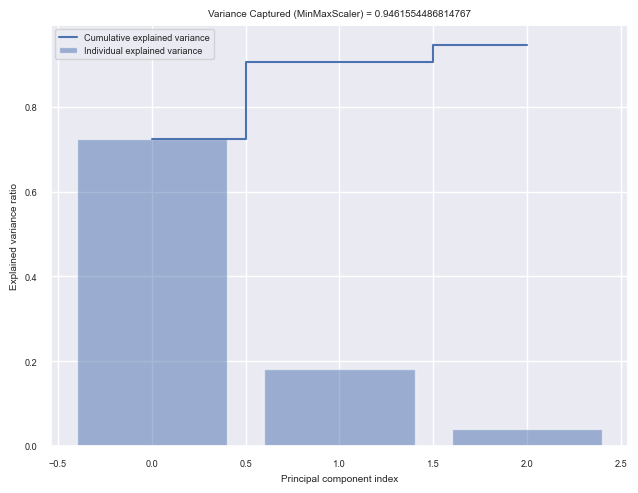

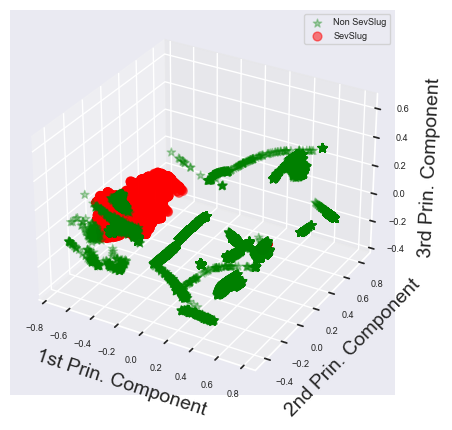

In [28]:
preproc_pipeline = make_pipeline(minmax_scaler_pipeline, PCA(n_components=3))
preproc_pipeline.fit(X_train)
X_train_reduced = preproc_pipeline.transform(X_train)
plot_cumul_sum(preproc_pipeline.named_steps['pca'].explained_variance_ratio_, 'MinMaxScaler')
plot_3d_chart(X_train_reduced, y_train)

## Machine Learning

In [29]:
# DummyClassifier
dummy_pipeline = make_pipeline(StandardScaler(), PCA(n_components=3), DummyClassifier())
dummy_pipeline.fit(X_train, y_train)

# confirming if score for Dummy classifier results from a balanced dataset
score = dummy_pipeline.score(X_train, y_train)
y_predicted = dummy_pipeline.predict(X_test)

print("Score: ", score)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted))

Score:  0.5000301624246568
Accuracy:  0.4999296212450002


### Linear SVC
#### Running pipeline from file

In [30]:
with open('linear_svc_pipeline.pkl', 'rb') as f:
    linear_svc_pipeline = pickle.load(f)
    
linear_svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=3))])),
                ('linearsvc', LinearSVC(C=1e-05, dual=False, penalty='l1'))])

In [31]:
score = linear_svc_pipeline.score(X_train, y_train)
y_predicted_lin_clf = linear_svc_pipeline.predict(X_test)

print("Score: ", score)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted_lin_clf))

Score:  0.9667622647959261
Accuracy:  0.9671096618300822


#### Hyperparameter optimisation and Model training

In [ ]:
%%time
# TRAINING THE MODEL

from sklearn.svm import LinearSVC

linear_svc_preproc_pipeline = make_pipeline(StandardScaler(), PCA(n_components=3))

linear_svc_pipeline = make_pipeline(linear_svc_preproc_pipeline, LinearSVC())

param_grid = {
    'linearsvc__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'linearsvc__penalty':['l1', 'l2'],
    'linearsvc__dual': [False, True]
}

grid_search_lsvc = GridSearchCV(
    linear_svc_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

grid_search_lsvc.fit(X_train, y_train)

print("best accuracy", grid_search_lsvc.best_score_)
print(grid_search_lsvc.best_estimator_)

linear_svc_pipeline = make_pipeline(
    linear_svc_preproc_pipeline, 
    LinearSVC(
        dual=grid_search_lsvc.best_params_['linearsvc__dual'],
        C=grid_search_lsvc.best_params_['linearsvc__C'],
        penalty=grid_search_lsvc.best_params_['linearsvc__penalty']
    )
)

linear_svc_pipeline.fit(X_train, y_train)

with open('linear_svc_pipeline.pkl', 'wb') as f:
    pickle.dump(linear_svc_pipeline, f)

os.system('say "the Hyperparameters for Linear SVC were successfully found. Model was successfully saved."')

### SGD Classifier
#### Running pipeline from file

In [32]:
with open('sgd_pipeline.pkl', 'rb') as f:
    sgd_pipeline = pickle.load(f)
    
sgd_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=3))])),
                ('sgdclassifier', SGDClassifier(loss='log', max_iter=1))])

In [33]:
score = sgd_pipeline.score(X_train, y_train)
y_predicted_sgd = sgd_pipeline.predict(X_test)

print("Score: ", score)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted_sgd))

Score:  0.9746723606621658
Accuracy:  0.9749803525975625


#### Hyperparameter optimisation and Model training

In [ ]:
%%time

# TRAINING THE MODEL
from sklearn.linear_model import SGDClassifier

sgd_preproc_pipeline = make_pipeline(StandardScaler(), PCA(n_components=3))

sgd_pipeline = make_pipeline(sgd_preproc_pipeline, SGDClassifier())

param_grid = {
    'sgdclassifier__max_iter': [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000],
    'sgdclassifier__loss': [
        'hinge','log_loss','log','modified_huber','squared_hinge',
        'perceptron','squared_error','huber',
        'epsilon_insensitive','squared_epsilon_insensitive'
    ]
}

grid_search_sgd = GridSearchCV(
    sgd_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

grid_search_sgd.fit(X_train, y_train)

print("best accuracy", grid_search_sgd.best_score_)
print(grid_search_sgd.best_estimator_)

sgd_pipeline = make_pipeline(
    sgd_preproc_pipeline, 
    SGDClassifier(
        max_iter=grid_search_sgd.best_params_['sgdclassifier__max_iter'], 
        loss=grid_search_sgd.best_params_['sgdclassifier__loss']
    )
)

sgd_pipeline.fit(X_train, y_train)

with open('sgd_pipeline.pkl', 'wb') as f:
    pickle.dump(sgd_pipeline, f)

os.system('say "the Hyperparameters for SGD were successfully found. Model was successfully saved"')

### k-Nearest Neighbours
#### Running pipeline from file

In [34]:
with open('knn_pipeline.pkl', 'rb') as f:
    knn_pipeline = pickle.load(f)
    
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=3))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [35]:
%%time
score = knn_pipeline.score(X_train, y_train)
y_predicted_knn = knn_pipeline.predict(X_test)

print("Score: ", score)
print("Accuracy: ",metrics.accuracy_score(y_test, y_predicted_knn))

Score:  0.996894527028046
Accuracy:  0.9945749709687636
CPU times: user 32.7 s, sys: 254 ms, total: 33 s
Wall time: 31.7 s


#### Hyperparameter optimisation and Model training

In [ ]:
%%time
# TRAINING THE MODEL

from sklearn.neighbors import KNeighborsClassifier

knn_preproc_pipeline = make_pipeline(MinMaxScaler(), PCA(n_components=3))
knn_pipeline = make_pipeline(knn_preproc_pipeline, KNeighborsClassifier())

param_grid = {
    'kneighborsclassifier__n_neighbors': range(3, 100),
#     'weights': ['uniform'] # default
#     'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search_knn = GridSearchCV(
    knn_pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    scoring='accuracy',
    verbose=1
)

grid_search_knn.fit(X_train, y_train)

print("best accuracy", grid_search_knn.best_score_)
print(grid_search_knn.best_estimator_)

knn_pipeline = make_pipeline(
    knn_preproc_pipeline, 
    KNeighborsClassifier(
        n_neighbors=grid_search_knn.best_params_['kneighborsclassifier__n_neighbors']
    )
)

knn_pipeline.fit(X_train, y_train)

with open('knn_pipeline.pkl', 'wb') as f:
    pickle.dump(knn_pipeline, f)

os.system('say "the Hyperparameters for kNN were successfully found. Model was successfully saved."')

## Conclusion

### Classification Report

In [36]:
# generating a classification report for LinearSVC
cr_linearsvc = metrics.classification_report(y_test, y_predicted_lin_clf, digits=4)

# generating a classification report for SGD
cr_sgd = metrics.classification_report(y_test, y_predicted_sgd, digits=4)

# generating a classification report for kNN
cr_knn = metrics.classification_report(y_test, y_predicted_knn, digits=4)

#### Linear SVC

In [37]:
# printing classification report for LinearSVC
print(cr_linearsvc)

              precision    recall  f1-score   support

           0     0.9683    0.9659    0.9671    170482
           1     0.9660    0.9684    0.9672    170530

    accuracy                         0.9671    341012
   macro avg     0.9671    0.9671    0.9671    341012
weighted avg     0.9671    0.9671    0.9671    341012



#### SGD Classifier

In [38]:
# printing classification report for SGD
print(cr_sgd)

              precision    recall  f1-score   support

           0     0.9688    0.9816    0.9751    170482
           1     0.9814    0.9684    0.9748    170530

    accuracy                         0.9750    341012
   macro avg     0.9751    0.9750    0.9750    341012
weighted avg     0.9751    0.9750    0.9750    341012



#### k-Neighbours Classifier

In [39]:
# printing classification report for kNN classifier
print(cr_knn)

              precision    recall  f1-score   support

           0     0.9968    0.9923    0.9946    170482
           1     0.9924    0.9968    0.9946    170530

    accuracy                         0.9946    341012
   macro avg     0.9946    0.9946    0.9946    341012
weighted avg     0.9946    0.9946    0.9946    341012



### Confusion Matrix

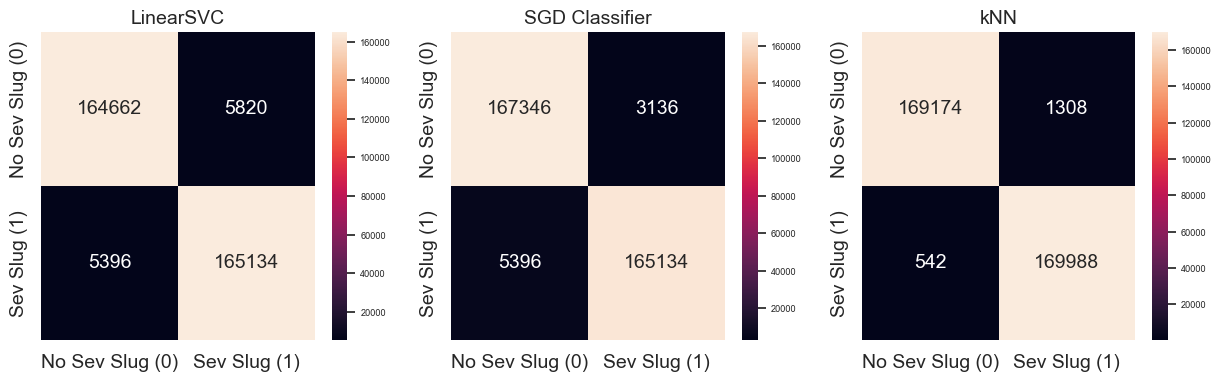

In [48]:
# setting labels valid for all following confusion matrices
cm_labels = ['No Sev Slug (0)', 'Sev Slug (1)']
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# plot each confusion matrix in a subplot
for i, y_predicted in enumerate([y_predicted_lin_clf, y_predicted_sgd, y_predicted_knn]):
    cm = metrics.confusion_matrix(y_test, y_predicted)
    cm_dataframe = pd.DataFrame(cm, index=cm_labels, columns=cm_labels)
    
    sns.heatmap(cm_dataframe, annot=True, fmt='d', ax=axs[i], cbar=True, annot_kws={"fontsize": 14})
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    titles = ['LinearSVC','SGD Classifier', 'kNN']
    axs[i].set_title(titles[i], fontsize=14)    
        
plt.show()


### 10-Fold Cross Validation

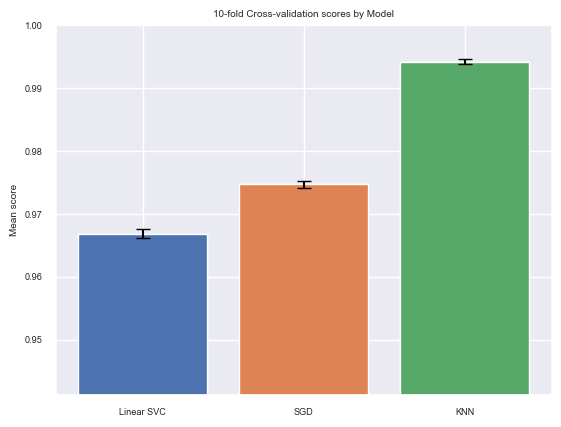

CPU times: user 2min 38s, sys: 16.1 s, total: 2min 54s
Wall time: 56.2 s


In [49]:
%%time 

# running cross validation
pipelines = [('Linear SVC', linear_svc_pipeline),
             ('SGD', sgd_pipeline),
             ('KNN', knn_pipeline)]

mean_scores = []
std_devs = []

for pipeline_name, pipeline in pipelines:
    scores = cross_val_score(pipeline, X_train, y_train, cv=10)
    mean_score = np.mean(scores)
    std_dev = np.std(scores)
    
    mean_scores.append(mean_score)
    std_devs.append(std_dev)

min_score = baseline_score - max(std_devs)



# plotting chart to compare mean scores
fig, ax = plt.subplots()
ax.bar([p[0] for p in pipelines], mean_scores, align='center', alpha=0.8)
ax.errorbar([p[0] for p in pipelines], mean_scores, yerr=std_devs, fmt='none', color='black', capsize=5)

ax.set_title('10-fold Cross-validation scores by Model')
ax.set_ylabel('Mean score')

for i in range(len(pipelines)):
    pipeline_name = pipelines[i][0]
    mean_score = mean_scores[i]
    std_dev = std_devs[i]
    height = mean_score - min_score
    bottom = min_score
    ax.bar(pipeline_name, height, bottom=bottom, color='C' + str(i))

ax.set_ylim([min_score, 1])
plt.show()
